<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/Colab/Landsat_ANN_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyrsgis

In [25]:
import ee
import geemap
from google.colab import drive
import math, random, glob, time
random.seed(2)
import numpy as np
from pyrsgis import raster, convert

Uso de ANN para clasificacion de Landsat

In [4]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-viacheslavs')

Lectura de capas de datos

In [5]:
punto_interes = ee.Geometry.Point([-103.76, 19.75])
print(punto_interes.getInfo())

L8_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(punto_interes).filterDate('2015-03-01', '2015-05-15')
print(L8_collection.size().getInfo())

# Load an image (Landsat 8).
L8_image = L8_collection.first()

# Load builtup 2015 (res 100 m)
ghs_built_image = ee.Image('JRC/GHSL/P2023A/GHS_BUILT_S/2015')
built_2015_lr = ghs_built_image.select('built_surface')

# Load builtup 2015 (res 10 m)
built_2015_hr = ee.Image('DLR/WSF/WSF2015/v1')

# blackBackground = ee.Image(0);


{'type': 'Point', 'coordinates': [-103.76, 19.75]}
4


Visualizar

In [6]:

Map = geemap.Map()
# Center the map and display the image.
Map.centerObject(punto_interes, 8)

# Define the visualization parameters L8
vizParams_L8 = {
  'bands': ['SR_B5', 'SR_B4', 'SR_B3'],
   'min': 5000,
   'max': 15000
  #'gamma': [0.95, 1.1, 1]
}
# Define the visualization parameters Builtup LR
vizBuiltup_LR = {
   'min': 0,
   'max': 1,
  'palette': ['white','black']
}
# Define the visualization parameters Builtup HR
vizBuiltup_HR = {
  min: 0,
  max: 255,
  'palette': ['white','black']
}

# Add layers
Map.addLayer(L8_image, vizParams_L8, 'Composición de falso color', True, 0.5)
Map.addLayer(built_2015_lr, vizBuiltup_LR, 'Builtup 2015 100m', True, 0.5)
Map.addLayer(built_2015_hr, vizBuiltup_HR, 'Builtup 2015 10m', True, 0.5)

# Display the map
Map


Map(center=[19.75, -103.76], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

Pruebas para convertir a numpy

None
{'type': 'Projection', 'crs': 'EPSG:32613', 'transform': [30, 0, 552285, 0, -30, 2352915]}
First array (102, 124, 6)
Second array (102, 125, 6)
Full array (102, 249, 6)


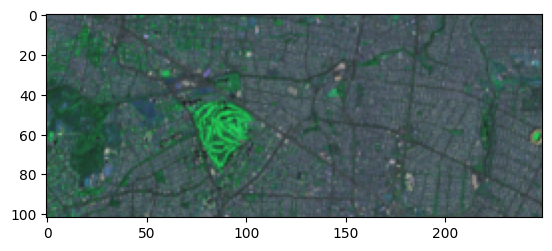

In [26]:
bands_L8 = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
bands_B = ['settlement']

def tile_to_numpy(image, rectangle, bands):
  ## extraccion de bandas en un region rectangular
  image_tile = image.sampleRectangle(region=rectangle,defaultValue=0)
  first_band = image_tile.get(bands[0])
  band_array_np = np.array(first_band.getInfo())
  band_array_np = np.expand_dims(band_array_np, 2)
  for b in bands[1:]:
    b_arr = image_tile.get(b)
    b_arr_np = np.array(b_arr.getInfo())
    b_arr_np = np.expand_dims(b_arr_np, 2)
    #print(b_arr_np.shape)
    #print(band_array_np.shape)
    band_array_np = np.concatenate((band_array_np, b_arr_np), 2)
  return band_array_np



image_meta = L8_image.getInfo()
imagename = image_meta.get('properties',{}).get('PRODUCT_ID')
print(imagename)

projection = L8_image.projection().getInfo();
print(projection)

#print(geemap.image_props(image).getInfo())

# definición de un region pequeño para el analisis
aoi1 = ee.Geometry.Polygon(
        [[[-103.39846006557397, 20.721686475573005],
          [-103.39846006557397, 20.694710560279958],
          [-103.36309782192163, 20.694710560279958],
          [-103.36309782192163, 20.721686475573005]]], None, False);
aoi2 = ee.Geometry.Polygon(
        [[[-103.36309782192163, 20.721686475573005],
          [-103.36309782192163, 20.694710560279958],
          [-103.32773557826929, 20.694710560279958],
          [-103.32773557826929, 20.721686475573005]]], None, False);


array1 = tile_to_numpy(L8_image, aoi1, bands_L8)
print("First array", array1.shape)
array2 = tile_to_numpy(L8_image, aoi2, bands_L8)
print("Second array", array2.shape)


array_full = np.concatenate((array1, array2), 1)
print("Full array", array_full.shape)

import matplotlib.pyplot as plt

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_test = (255*((array_full - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_test[:,:,2:5])
plt.show()



{'type': 'Image', 'bands': [{'id': 'settlement', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'crs': 'EPSG:32613', 'crs_transform': [30, 0, 552285, 0, -30, 2352915]}], 'id': 'DLR/WSF/WSF2015/v1', 'version': 1641990115208687, 'properties': {'date_range': [1420070400000, 1451606400000], 'period': 0, 'type_name': 'Image', 'keywords': ['landcover', 'landsat-derived', 'sentinel1-derived', 'settlement', 'urban'], 'system:time_end': 1451520000000, 'description': '<p>The World Settlement Footprint (WSF) 2015 is a 10m resolution binary mask\noutlining the extent of human settlements globally derived by means of\n2014-2015 multitemporal Landsat-8 and Sentinel-1 imagery (of which ~217,000 and\n~107,000 scenes have been processed, respectively).</p><p>The temporal dynamics of human settlements over time are\nsensibly different than those of all other non-settlement information classes.\nHence, given all the multitemporal images available over a region of interest\n

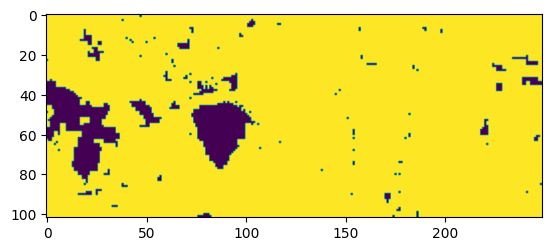

In [27]:
## Resample
built_2015_hr_mean = built_2015_hr.reproject(projection.get('crs'), projection.get('transform'))

print(built_2015_hr_mean.getInfo())

#proj = ee.Projection('EPSG:4326').getInfo()
#built_2015_hr_mean = built_2015_hr.reproject(proj.get('crs'), None, 30)
#print(built_2015_hr_mean.getInfo())

Map1 = geemap.Map()
Map1.centerObject(punto_interes, 8)
Map1.addLayer(built_2015_hr_mean, vizBuiltup_HR, 'Builtup 2015 10m', True, 0.5)
Map1

array3 = tile_to_numpy(built_2015_hr_mean, aoi1, bands_B)
print("B array 3", array3.shape)
array4 = tile_to_numpy(built_2015_hr_mean, aoi2, bands_B)
print("B array 4", array4.shape)

array_labels = np.concatenate((array3, array4), 1)
print("Full labels array", array_labels.shape)

# Scale the data to [0, 255] to show as an RGB image.
B_img_test = (array_labels).astype('uint8')
plt.imshow(B_img_test[:,:,0])
plt.show()


In [34]:
array_full_t = np.transpose(array_full, (2, 0, 1))
array_labels_t = np.transpose(array_labels, (2, 0, 1))
print(array_full_t.shape)
print(array_labels_t.shape)
x_features = convert.array_to_table(array_full_t)
y_labels = convert.array_to_table(array_labels_t)
#featuresHyderabad = changeDimension(featuresHyderabad)
nBands = x_features.shape[1]
#labelBangalore = (labelBangalore == 1).astype(int)

print(x_features.shape)
print(x_features)
print(y_labels.shape)
print(y_labels)

(6, 102, 249)
(1, 102, 249)
(25398, 6)
[[13055 14038 15793 16994 17994 16298]
 [11986 13491 14971 16679 17979 16413]
 [11411 13234 14567 16829 17443 15831]
 ...
 [ 9434 10024 10446 13821 13243 12324]
 [10319 10916 11821 14878 14932 13856]
 [11988 12709 13541 16119 15902 14938]]
(25398, 1)
[[255]
 [255]
 [255]
 ...
 [255]
 [255]
 [255]]


In [36]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(x_features, y_labels, test_size=0.4, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

# Normalise the data
yTrain = yTrain / 255
yTest = yTest / 255
xTrain = xTrain / 32768
xTest = xTest / 32768

print(xTrain)
print(yTrain)

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

print(xTrain.shape, xTest.shape)

(15238, 6)
(15238, 1)
(10160, 6)
(10160, 1)
[[0.32714844 0.36120605 0.41702271 0.45376587 0.53646851 0.50585938]
 [0.36019897 0.38583374 0.41516113 0.47723389 0.49517822 0.45193481]
 [0.32846069 0.35913086 0.38757324 0.42495728 0.4392395  0.40985107]
 ...
 [0.35540771 0.39575195 0.4180603  0.50219727 0.50311279 0.45187378]
 [0.30560303 0.32565308 0.34085083 0.4664917  0.42913818 0.38497925]
 [0.35067749 0.35906982 0.39105225 0.42843628 0.42391968 0.39492798]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
(15238, 1, 6) (10160, 1, 6)


Train neural network

In [42]:
from tensorflow import keras

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model.fit(xTrain, yTrain, epochs=2)

Epoch 1/2
477/477 [==============================] - 1s 2ms/step - loss: 0.3092 - accuracy: 0.8946
Epoch 2/2
477/477 [==============================] - 1s 2ms/step - loss: 0.2408 - accuracy: 0.9224


In [43]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Predict for test data
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

# Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)

print("Confusion matrix:\n", cMatrix)
print("\nprecision: %.3f, recall: %.3f" % (pScore, rScore))

318/318 [==============================] - 0s 1ms/step
Confusion matrix:
 [[   0  773]
 [   0 9387]]

precision: 0.924, recall: 1.000


794/794 [==============================] - 2s 2ms/step


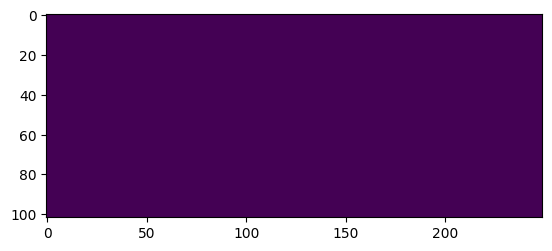

In [41]:
x_features_n = x_features / 32768
x_features_n = x_features_n.reshape((x_features_n.shape[0], 1, x_features_n.shape[1]))

predicted = model.predict(x_features_n)
predicted = predicted[:,1]


#Export raster
prediction = np.reshape(predicted, (array_labels.shape[0], array_labels.shape[1]))
B_img_pred = (prediction).astype('uint8')
plt.imshow(B_img_pred[:,:])
plt.show()

In [40]:
def loadTiff(in_image, init=None, size_img=None):
    src = raster.read(in_image, bands='all')
    nbands = src.RasterCount
    in_band = src.GetRasterBand(1)  # load one band for size reference
    if init is None:
        xinit,yinit = (0, 0)
    else:
        xinit,yinit = init
    if size_img is None:
        block_xsize, block_ysize = (in_band.XSize, in_band.YSize)
    else:
        block_xsize, block_ysize = size_img

    # read the (multiband) file into an array
    image = src.ReadAsArray(xinit, yinit, block_xsize, block_ysize)
    # reshape from bandsxheightxwidth to wxhxb
    image = np.moveaxis(image, 0, -1)
    return image, block_ysize, block_xsize, nbands

#[img, xsize, ysize, nbands] = loadTiff(os.path.join(drive,image))

In [41]:
#task_config = {
#    'image': image,
#    'fileFormat': 'GeoTIFF',
#    'folder': 'test_L8_image',
#    'fileNamePrefix': imagename[0:19],
#    'crs': projection,
#    'crsTransform': projection.transform,
#    'description': "clipped area",
#    'scale':20,
#    'region':poly_area
#}


# This is how we order it to start
#task = ee.batch.Export.image.toDrive(**task_config )
#task.start()

### check task status - you can see if it failed, it's running or finished
#task.status()

In [42]:
#drive = "/content/drive/MyDrive/exercise/"

### loading the file
#s2_data = "test_L8_image"

### loading and checking
#ds1, bands = raster.read(s2_data)
#print(ds1)
#print(bands.shape)